# Bank Simulator

Copyright 2019 IBM Corp.

# Load Trained Classifier

* This data was created by running the notebook train-on-core-features.ipynb

In [2]:
import pickle, os

home_dir = "../data"

charge_off_classifier_core_pkl = os.path.join(home_dir, "co_clf_core.pkl")

with open(charge_off_classifier_core_pkl,'rb') as f:
    data_df, idx_train, idx_test, idx_validate, clf_core, core_features, analytics = pickle.load(f)

# Import packages

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

import matplotlib.ticker as tkr
from matplotlib import rcParams

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Useful functions

In [4]:
def print_score(clf, X_train, y_train, X_test, y_test, train=False, plot_features=False, features=None):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  
        
    if plot_features and features is not None:
        # Get top features
        feature_importances = pd.DataFrame(clf.feature_importances_, 
                                   index = features,
                                   columns=['importance']).\
                                   sort_values('importance',ascending=False)
        # Plot
        
        rcParams['figure.figsize'] = 20, 10
        rcParams['font.size'] = 16
        feature_importances.iloc[:10,:].plot(kind='barh')
        plt.show()

In [5]:
def calc_threshold(X, gain_col, plot=False):

    thrs = [0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
            0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
            0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
            0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 ]

    gain = np.array([X.loc[X.score <= thr, gain_col].sum()  for thr in thrs])

    if plot:
        plt.plot(thrs, gain)
        plt.xlabel('Threshold')
        plt.ylabel(gain_col)
        plt.show()

  
    b = np.argmax(gain)
    optimal_threshold = thrs[b]
    
    return optimal_threshold

In [6]:
def evaluate_invest(sample_df, invest_sum, optimal_threshold, plot=False ):
    
    #eval_fields = [gain_col, 'loan_amnt', 'LoanStatus', 'recoveries', 'total_rec_prncp', 'total_rec_int']

    # Apply the selection rule
    selected_df = sample_df.loc[sample_df.score <= optimal_threshold, :]

    # Buy the loans up to the investment sum
    invested_df = selected_df.loc[selected_df['loan_amnt'].cumsum() <= invest_sum, :]
    
    return invested_df, selected_df


In [7]:
def payments(row):
    #message = ""
    
    rate  = float( row['int_rate']/100 )
    rate /= float(12)
    
    N = int(row['term'])
    
    if N == 0:
        N = 36
    else:
        N = 60
    
    L = row['funded_amnt']   
    install = row['installment']  
    total_rec_int = row['total_rec_int']
    total_rec_prncp = row['total_rec_prncp']
    recoveries = row['recoveries']
    total_pymnt = row['total_pymnt']
    life_of_loan = int(row['LifeOfLoan'])
    charged_off = (row['LoanStatus'] == 1.0)
    
    int_rec = []
    prn_rec = []
    prn_rem = []
    
    P = L
    tot_int = 0
    tot_prn = 0
    tot_rec = 0
  
    for n in range(N):
      
        # Normal payments
        int_pmnt = P*rate
        prn_pmnt = install - int_pmnt

        # End of interest payments is termination condition
        if not (int_pmnt + tot_int) < total_rec_int:
            #message = "Interest payments terminated"
            int_pmnt = total_rec_int - tot_int
            if (int_pmnt < 0):
             #   print("int neg 1")
                int_rec[-1] += int_pmnt
                break
            prn_pmnt = total_rec_prncp - tot_prn
            tot_int += int_pmnt
            tot_prn += prn_pmnt
            int_rec.append(int_pmnt)
            prn_rec.append(prn_pmnt)
            
            break
 
        # In default, last few payments are considered interest?
        if not (prn_pmnt + tot_prn) < total_rec_prncp:
            prn_pmnt = total_rec_prncp - tot_prn
            int_pmnt = install - prn_pmnt
            
        tot_int += int_pmnt
        tot_prn += prn_pmnt
        
               
        P -= prn_pmnt

        int_rec.append(int_pmnt)
        prn_rec.append(prn_pmnt)
        

    loss = L - tot_prn + recoveries
    
    return int_rec, prn_rec, n, loss

In [8]:
def loss(row, loss, delay):
    n = int( row["month"] + delay)
    l = row["loss"]
    loss[n] += l

In [9]:
def generate_series(invested_df, loss_delay, N=60):
    df = pd.DataFrame(invested_df.apply(payments, axis=1).to_list(), columns=["int","prn","month", "loss"])

    int_series = pd.DataFrame(df["int"].tolist()).fillna(value=0).aggregate(sum, axis=0).to_list()
    prn_series = pd.DataFrame(df["prn"].tolist()).fillna(value=0).aggregate(sum, axis=0).to_list()
    
    int_series += [0]*(N - len(int_series))
    prn_series += [0]*(N - len(prn_series))

    loss_series = np.zeros(N + loss_delay)
    df.apply(loss, axis=1, args=(loss_series, loss_delay))
    
    return int_series, prn_series, loss_series

In [10]:
def print_investment_analysis(invested_df, show_plot=False):
    # Calculate the return, amount invested, loss, gain
    invested_return = invested_df[gain_col] / invested_df['loan_amnt']
    invested_amnt = invested_df['loan_amnt'].sum()
    invested_loss = invested_df['loan_amnt'].sum() \
                - invested_df['total_rec_prncp'].sum() - invested_df['recoveries'].sum()
    invested_int  = invested_df['total_rec_int'].sum()
    invested_loss = max(invested_loss, 0)
    invested_gain = invested_df[gain_col].sum()
    return_on_investment = 100 * invested_gain / invested_amnt

    # Collect some loan statistics
    num_loans = invested_df.shape[0]
    num_failed = invested_df.loc[invested_df['LoanStatus'] > 0, 'LoanStatus'].count()

    print("\tInvested ${0:,.2f}".format(invested_amnt))
    print("\tReturn    {0:.4f}%".format(return_on_investment))
    print("\t\tNumber loans:  {0:}".format(num_loans))
    print("\t\tNumber failed: {0:}".format(num_failed))
    print("\t\tInterest paid:      ${0:15,.2f}".format(invested_int))
    print("\t\tLoss of principal:  ${0:15,.2f}".format(invested_loss))
    print("\t\tTotal gain:         ${0:15,.2f}".format(invested_gain))

    if show_plot:
        invested_return.hist(bins=150)
        plt.xlabel("Return of Loan")
        plt.ylabel("Number of loans")
        plt.show()

In [11]:
def print_payments(row, int_rec, prn_rec):
    rate  = float( row['int_rate']/100 )
    rate /= float(12)

    N = int(row['term'])
    if N == 0:
        N = 36
    else:
        N = 60

    L = row['funded_amnt']   
    install = L * (rate * pow(1+rate,N))/(pow(1+rate,N) - 1)
    print("Installment calculated: {0:,.2f} \t Installment from LC data: {1:,.2f}"
         .format(install, row['installment']))
    
    total_rec_int = row['total_rec_int']
    total_rec_prncp = row['total_rec_prncp']
    recoveries = row['recoveries']
    total_pymnt = row['total_pymnt']
    life_of_loan = int(row['LifeOfLoan'])
    charged_off = (row['LoanStatus'] == 1.0)

    print("Loan: ${1:,.0f}\tTerm of loan: {3:2d} months \tRate {2:.2f}% ".format(install, L, row['int_rate'], N))
    print("               \tLife of loan: {0:2d} months \tCharged_off: {1:}"
              .format(life_of_loan, charged_off))
    print("               \tInterest: ${0:,.2f} Principal: ${1:,.2f} Total ${2:,.2f} Recoveries ${3:,.2f}"
              .format(total_rec_int, total_rec_prncp, total_pymnt, recoveries))


    tot_prn = 0
    tot_int = 0
    tot_rec = 0
    P = L
    for n in range(len(int_rec)):
        P -= prn_rec[n]
        tot_prn += prn_rec[n]
        tot_int += int_rec[n]
        print("month {3:4d} principal payment {0:8.2f} interest payment {2:8.2f} principal remaining {1:8.2f} principal paid {4:8.2f}"
                  .format(prn_rec[n], P, int_rec[n], n, tot_prn))


    tot_rec = tot_prn + tot_int + recoveries
    print("Interest: ${0:,.2f} Principal: ${1:,.2f} Total: ${3:,.2f} Net Loss: ${2:,.2f}"
              .format(tot_int, tot_prn, L - tot_prn - recoveries, tot_rec))


 



        

In [12]:

def plot_bank_run(dyn_params, opt_params, capital, income, losses, assets, bankrupt):
    # figure size in inches
    rcParams['figure.figsize'] = 8,4.5
    rcParams['font.size'] = 16

    plt.tight_layout()


    N = len(capital)
    if bankrupt:
        N -= 1
        capital = capital[:N]
        income  = income[:N]
        losses  = losses[:N]
        assets  = assets[:N]

    ax = plt.subplot()
    ax.plot(range(N), capital, 'g', label='Capital', )
    ax.plot(range(N), income,  'c', label='Income')
    ax.plot(range(N), losses,  'r', label='Losses')
    ax.yaxis.set_major_formatter(tkr.StrMethodFormatter('${x:,.0f}'))
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.legend()

    plt.title("Lending Club bank: {0:.0f}Y performance \n Threshold {1:.3f}, leverage {2:2d}:1, Loss delay {3:d}M"
              .format(N/4, opt_params['threshold'], opt_params['leverage_ratio'], 
                      opt_params['loss_delay']))

    skip_ratios = True
    
    if skip_ratios:
        ann_ret_exponent = float(12) / float(dyn_params['inv_cycle'])

        ROA = (np.array(income) - np.array(losses)) / np.array(assets)
        ROA = np.power(ROA + 1, ann_ret_exponent) - 1 

        prev_capital = np.zeros(N)
        prev_capital[0] = opt_params['starting_capital']
        prev_capital[1:] = capital[:N-1]
        next_capital = np.array(capital)
        ROC = (next_capital - prev_capital)/prev_capital

        ROC = np.power(ROC+1, ann_ret_exponent) - 1

        LR  = np.array(losses) / np.array(assets)

        LR  = np.power(LR+1, ann_ret_exponent) - 1


        #ax = plt.subplot(3,1,2)
        #ax.plot(range(1,N), ROC[1:],  label='Return on Capital')
        #ax.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.4f}'))
        #ax.xaxis.set_major_locator(plt.MultipleLocator(4))
        #plt.legend()

        #ax = plt.subplot(3,1,3)
        #ax.plot(range(1,N), LR[1:],   label='Loss Ratio')
        #ax.plot(range(1,N), ROA[1:],   label='Return on Assets')
        #ax.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.4f}'))
        #ax.xaxis.set_major_locator(plt.MultipleLocator(4))
        #plt.legend()

    plt.xlabel("Quarters")

    plt.show()

In [13]:
def bank_run(dyn_params, dec_params, do_print=False, do_plot=False):

    # sampled loans
    df_list = dyn_params['sample_df_list']
    
    # Initial cash
    cash = dec_params['starting_capital']

    # Initial assets
    assets = 0

    # Initial liabilities
    liabilities = 0

    # Initial capital
    capital = cash + assets - liabilities
    
    # Series to output
    asset_series   = []
    capital_series = []
    income_series  = []
    losses_series  = []


    # Monthly rate on loan
    rate_3M  = (dyn_params['inv_cycle'] / 12) * (dec_params['loan_interest_rate']/100 )

    # Set up data structures
    interest_income = np.zeros(3 * dyn_params['length_of_run'])
    principal_pymnt = np.zeros(3 * dyn_params['length_of_run'])
    loss_recognized = np.zeros(3 * dyn_params['length_of_run'] + dec_params['loss_delay'])

    # Initial values for run
    old_loan   = 0
    old_d  = 0
    n = 0
    bankrupt = False
    for d in range(dyn_params['inv_cycle'] ,1+dyn_params['length_of_run'],dyn_params['inv_cycle']):

        # Borrow 
        new_loan = dec_params['leverage_ratio'] * capital
        cash += new_loan

        # Pay back old loan
        cash -= old_loan

        # Invest everything
        to_invest = max(0, cash)

        if to_invest > 0.0:

            # Make investments
            invested_df, selected_df = \
                evaluate_invest(df_list[n], to_invest, dec_params['threshold'])

            n+=1
            
            # Total actually invested
            invested = invested_df['loan_amnt'].sum()

            # Update cash balance
            cash   -= invested  

            # Update assets
            assets += invested

            # Calculate outcomes of new investment
            int_series, prn_series, lss_series = generate_series(invested_df, dec_params['loss_delay'])

            # Add new outcomes to tails of old outcomes
            interest_income[old_d: len(int_series) + old_d] += int_series
            principal_pymnt[old_d: len(prn_series) + old_d] += prn_series
            loss_recognized[old_d: len(lss_series) + old_d] += lss_series

        if do_print:
            print("Month: {0:2d} \t New investment ${1:,.2f} New loan ${2:,.2f}".format(d, invested, new_loan))

        # Calculate interest, principal, losses from old_d to d
        int_calc = interest_income[old_d:d].sum()
        prn_calc = principal_pymnt[old_d:d].sum()
        loss_calc = loss_recognized[old_d:d].sum()

        # Loan interest due
        int_loan = new_loan * (rate_3M)

        # Update cash on hand
        cash += int_calc
        cash += prn_calc
        cash -= int_loan

        if do_print:
            print("              \t Income: {1:,.2f} Expense: {2:,.2f} Net income: {3:,.2f} Cash: {4:,.2f}"
                 .format(d, int_calc, int_loan, int_calc - int_loan, cash))
            print("              \t Loss ratio {0:,.2f}".format(loss_calc/assets))

        # Update assets - deduct losses from assets
        assets -= (loss_calc + prn_calc)

        # Update liabilities
        liabilities -= old_loan
        liabilities += new_loan

        # Balance sheet
        capital     = cash + assets - liabilities

        if do_print:
            print("             \t Assets: {1:,.2f} Liabilities: {2:,.2f} Capital: {3:,.2f} \n"
                  .format(d, assets, liabilities, capital))

        # Record
        asset_series.append(assets)
        capital_series.append(capital)
        income_series.append(int_calc - int_loan)
        losses_series.append(loss_calc)
        
        # Bankrupt!
        if capital < 0:
            bankrupt = True
            print("Bankrupt!")
            break

        # Update
        old_d = d
        old_loan  = new_loan
        
    if do_plot:
        plot_bank_run(dyn_params, dec_params, capital_series, income_series, losses_series, asset_series, bankrupt)
        
    return capital_series, income_series, losses_series, asset_series, bankrupt
    
    

# Print scores

In [15]:
# Define train, test, and validate df
train_df    = data_df.loc[idx_train, :]
test_df     = data_df.loc[idx_test, :]
validate_df = data_df.loc[idx_validate, :]

print("Number of loans in Train    set: {}".format(train_df.shape[0]))
print("Number of loans in Test     set: {}".format(test_df.shape[0]))
print("Number of loans in Validate set: {}".format(validate_df.shape[0]))

Number of loans in Train    set: 553049
Number of loans in Test     set: 97597
Number of loans in Validate set: 650647


Test Result:

accuracy score: 0.7981

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.98      0.89     77964
         1.0       0.49      0.08      0.13     19633

    accuracy                           0.80     97597
   macro avg       0.65      0.53      0.51     97597
weighted avg       0.74      0.80      0.73     97597


Confusion Matrix: 
 [[76416  1548]
 [18155  1478]]



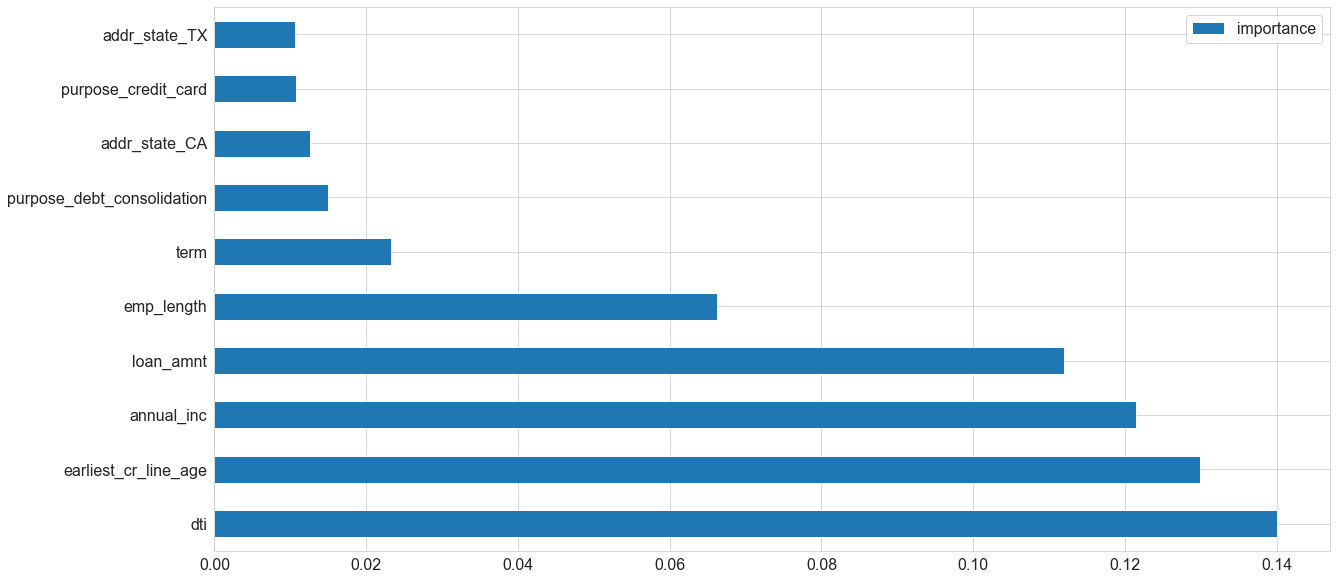

In [16]:
# Just for sanity, print the scores and features for the classifier
print_score(clf_core, train_df[core_features], train_df['LoanStatus'], test_df[core_features], test_df['LoanStatus'], 
           plot_features=True, features=core_features)

# Calculate optimal thresholds
This is useful as an upper bound on thresholds

In [17]:
# select criterion
gain_col = 'TotalGain'

test_df['score'] = clf_core.predict_proba(test_df[core_features])[:,1]    
opt_threshold    = calc_threshold(test_df, gain_col)

print("Threshold is {0:.4f}".format(opt_threshold))

Threshold is 0.3000


# Simulate lending

In [18]:
# Generate sample of loans

sample_params = {'inv_cycle':           3,
                 'sample_size':         2000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]
    
    sample_df_list.append(sample_df)

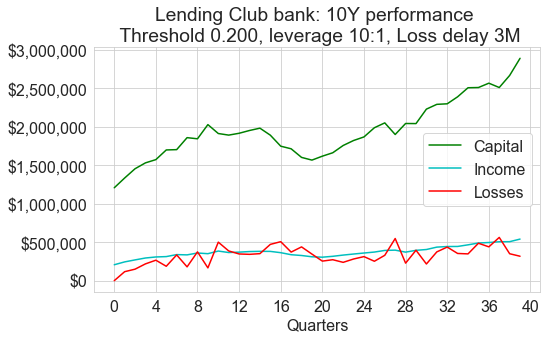

In [21]:
# Simulate the bank
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3.0,
              'threshold':           opt_threshold - 0.1 
             }

capital, income, losses, assets, bankrupt = bank_run(sample_params, opt_params, do_print=False, do_plot=True)